# Cooke triplet example with ray aiming

I'm using this "textbook" example of a Cooke triplet, to see if I can do ray aiming. That's where you adjust the ray bundles from each field so they all cross over at the Stop surface.

https://wp.optics.arizona.edu/jsasian/wp-content/uploads/sites/33/2016/03/L20_OPTI517_Cooke_triplet.pdf

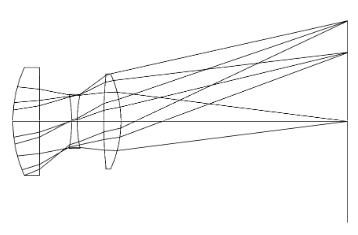

In [83]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

import opticsRayTrace.rayTraceTools as rtt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
'''

This is just copy-pasted from the author's slide show. I added the "N" to the glasses.

'''

s = '''1 STANDARD 23.713 4.831 N-LAK9
2 STANDARD 7331.288 5.86
STO STANDARD -24.456 0.975 N-SF5
4 STANDARD 21.896 4.822
5 STANDARD 86.759 3.127 N-LAK9
6 STANDARD -20.4942 41.10346'''

t = [u.split() for u in s.split('\n')]
t

[['1', 'STANDARD', '23.713', '4.831', 'N-LAK9'],
 ['2', 'STANDARD', '7331.288', '5.86'],
 ['STO', 'STANDARD', '-24.456', '0.975', 'N-SF5'],
 ['4', 'STANDARD', '21.896', '4.822'],
 ['5', 'STANDARD', '86.759', '3.127', 'N-LAK9'],
 ['6', 'STANDARD', '-20.4942', '41.10346']]

In [108]:
'''

A crude function to turn the surface list into my format

'''

def s2surf(s):
    print(s)
    surf = {'surf': 'conic',
            'c': 1/float(s[2]),
            'k': 0,
            'dist': float(s[3]),
           'draw_radius': 10}
    if len(s) > 4:
        surf['material'] = s[4]
    return surf
    
surface_list = [{'surf': 'dummy', 'dist': -10}, {'surf': 'dummy', 'dist': 10}] + [s2surf(u) for u in t] + [{'surf': 'dummy'}]
stop_surface = 4
surface_list[stop_surface]['stop'] = True

['1', 'STANDARD', '23.713', '4.831', 'N-LAK9']
['2', 'STANDARD', '7331.288', '5.86']
['STO', 'STANDARD', '-24.456', '0.975', 'N-SF5']
['4', 'STANDARD', '21.896', '4.822']
['5', 'STANDARD', '86.759', '3.127', 'N-LAK9']
['6', 'STANDARD', '-20.4942', '41.10346']


Text(0.5, 1.0, 'Cooke triplet')

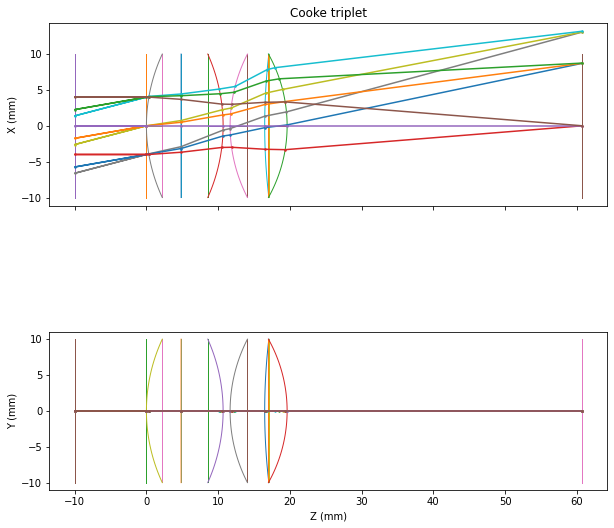

In [133]:
'''

Trace rays through the model, without any ray aiming. The first concave surface is where the
stop is supposed to be. I'll figure out a way to draw markers for it ... later

'''

geometry = rtt.build_geometry(surface_list)
lsf = np.array([15, 10, 0]) #np.linspace(-10, 10, 3)
lsp = np.linspace(-4, 4, 3)
lsps = np.array([0, 0, 0])
field_rays = np.array([np.array([x*np.pi/180, 0, 1]) for x in lsf])
pupil_points = np.array([np.array([x, 0, 0]) for x in lsp])
pupil_shifts = np.array([np.array([x, 0, 0]) for x in lsps])
wavls = np.array([0.000633])
ray_table = rtt.new_ray_table(geometry, field_rays, pupil_points, wavls, infinite = True,
                             pupil_shifts = pupil_shifts)
rtt.propagate_ray(ray_table, geometry)
axd = rtt.new_plot_xy(figsize = (10, 10))
rtt.plot_faces(axd, geometry)
rtt.plot_rays(axd, geometry, ray_table, marker = '.', markersize = 3)
axd["axs"][0].set_title("Cooke triplet")

Text(0, 0.5, 'Merit function (a.u.)')

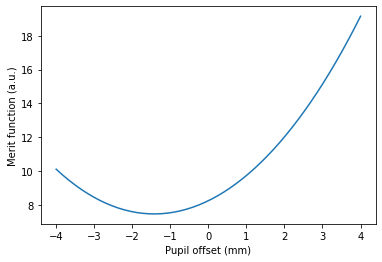

In [135]:
'''

I'm going to try a crude merit function that just computes the RMS X position of the
rays at the stop surface, and see if it goes through a minimum anywhere.

'''

def merit_function(lsps):
    # Already have surface list and geometry
    pupil_shifts = np.array([np.array([x, 0, 0]) for x in lsps])
    ray_table = rtt.new_ray_table(geometry, field_rays, pupil_points, wavls, infinite = True,
                             pupil_shifts = pupil_shifts)
    rtt.propagate_ray(ray_table, geometry)
    merit = np.average(ray_table[stop_surface, :, 0, 0]**2)
    return merit

za = np.linspace(-4, 4)
plt.plot(za, [merit_function([z, 0, -z]) for z in za])
plt.xlabel('Pupil offset (mm)')
plt.ylabel('Merit function (a.u.)')

In [136]:
'''

Now let's just ask Scipy to minimize it with no special settings

'''

m = minimize(merit_function, [0, 0, 0])
m['x']

array([-3.01394960e+00, -1.96107592e+00, -1.59921010e-08])

In [137]:
'''

Here are the new pupil shifts

'''

lsps_aimed = m['x']

Text(0.5, 1.0, 'Cooke triplet with ray aiming')

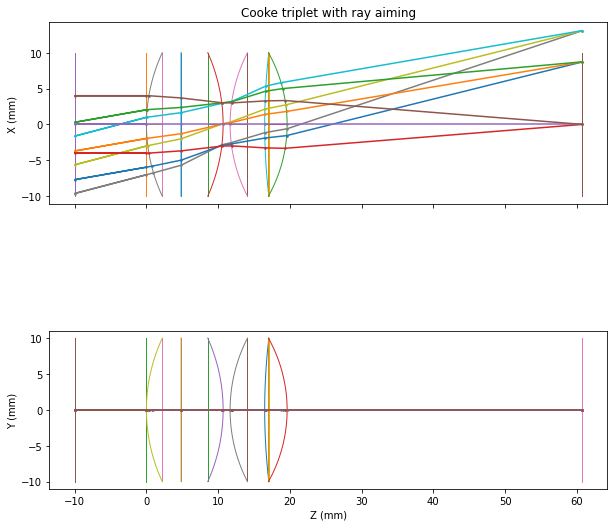

In [138]:
pupil_shifts = np.array([np.array([x, 0, 0]) for x in lsps_aimed])
ray_table = rtt.new_ray_table(geometry, field_rays, pupil_points, wavls, infinite = True,
                             pupil_shifts = pupil_shifts)
rtt.propagate_ray(ray_table, geometry)
axd = rtt.new_plot_xy(figsize = (10, 10))
rtt.plot_faces(axd, geometry)
rtt.plot_rays(axd, geometry, ray_table, marker = '.', markersize = 3)
axd["axs"][0].set_title("Cooke triplet with ray aiming")